In [73]:
from sqlalchemy.engine import create_engine, URL
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats


In [75]:
SERVER = 'localhost'  # localhost innebär att du ansluter till en server på din egen dator
DATABASE = 'AdventureWorks2022'

connection_string = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes;Encrypt=no'

connection_url = URL.create('mssql+pyodbc', query={'odbc_connect': connection_string})

engine = create_engine(connection_url)  # engine är anslutningsobjektet vi använder för att kommunicera med databasen.

In [79]:
query = """SELECT 
    P.ProductID,
    P.Name AS ProductName,
    SOH.SalesOrderID AS TransactionID,
    SOH.OrderDate AS TransactionDate,
    SOD.LineTotal AS TotalAmount,
    YEAR(SOH.OrderDate) AS Year,    
    MONTH(SOH.OrderDate) AS Month,  
    SUM(SOD.LineTotal) OVER (PARTITION BY P.ProductID, YEAR(SOH.OrderDate), MONTH(SOH.OrderDate)) AS TotalSale,
    SUM(SOD.LineTotal - (SOD.OrderQty * P.StandardCost)) OVER (PARTITION BY P.ProductID, YEAR(SOH.OrderDate), MONTH(SOH.OrderDate)) AS TotalProfit
    
FROM 
    Production.Product P
JOIN 
    Sales.SalesOrderDetail SOD ON P.ProductID = SOD.ProductID 
JOIN 
    Sales.SalesOrderHeader SOH ON SOD.SalesOrderID = SOH.SalesOrderID   
JOIN 
    Production.ProductSubcategory PSC ON P.ProductSubcategoryID = PSC.ProductSubcategoryID   
WHERE 
    PSC.ProductCategoryID = (SELECT ProductCategoryID FROM Production.ProductCategory WHERE Name = 'Bikes')
    
"""


In [83]:
# extracts the year,months from the orderdate
# Calculates the total profit by substracting the total cost(order quantity * standardcost) from the total sale amount
# 1st join is to link each product with its sales details
# 2nd join is to get the sale transaction details
# 3rd join is to get subcategory information

In [85]:
df = pd.read_sql(query,engine)


In [87]:
print(df)

       ProductID         ProductName  TransactionID TransactionDate  \
0            749    Road-150 Red, 62          45312      2012-01-01   
1            749    Road-150 Red, 62          45412      2012-01-11   
2            749    Road-150 Red, 62          45416      2012-01-11   
3            749    Road-150 Red, 62          45429      2012-01-13   
4            749    Road-150 Red, 62          45277      2012-01-01   
...          ...                 ...            ...             ...   
40026        999  Road-750 Black, 52          70375      2014-04-10   
40027        999  Road-750 Black, 52          70443      2014-04-11   
40028        999  Road-750 Black, 52          70590      2014-04-13   
40029        999  Road-750 Black, 52          69856      2014-04-03   
40030        999  Road-750 Black, 52          69858      2014-04-03   

       TotalAmount  Year  Month   TotalSale  TotalProfit  
0         2146.962  2012      1  241175.398   47930.2142  
1         3578.270  2012     

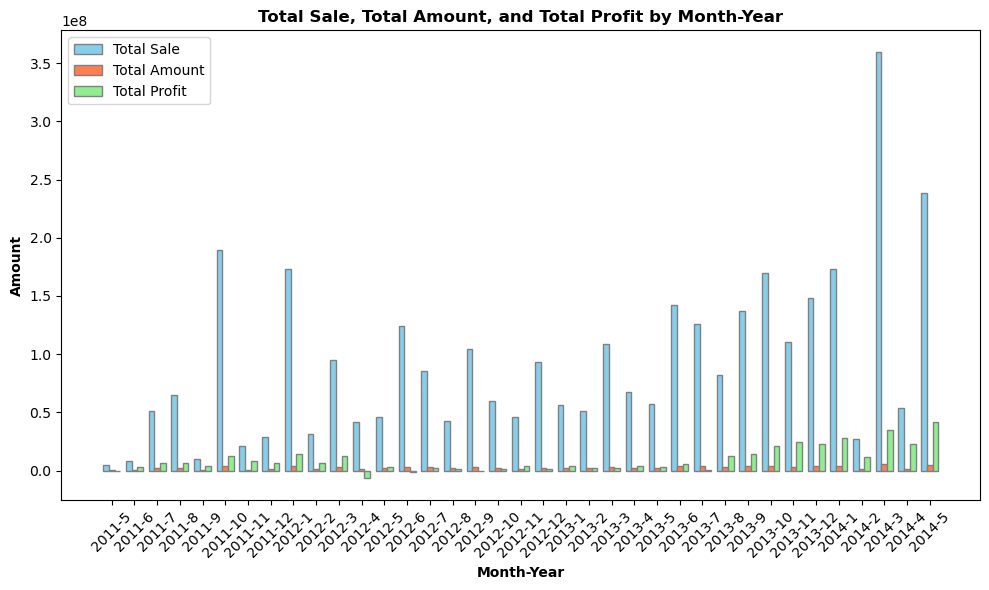

In [89]:
# Group by 'Year' and 'Month' and sum the specified columns
grouped_df = df.groupby(['Year', 'Month']).agg({'TotalSale': 'sum', 'TotalAmount': 'sum', 'TotalProfit': 'sum'}).reset_index()

# Create a new column for Month-Year
grouped_df['MonthYear'] = grouped_df['Year'].astype(str) + '-' + grouped_df['Month'].astype(str)

bar_width = 0.25

# Set position of bar on X axis
r1 = range(len(grouped_df['MonthYear'])) # Total sale
r2 = [x + bar_width for x in r1] # Total Amount
r3 = [x + bar_width for x in r2] # Profit

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(r1, grouped_df['TotalSale'], color='skyblue', width=bar_width, edgecolor='grey', label='Total Sale')
bars2 = ax.bar(r2, grouped_df['TotalAmount'], color='coral', width=bar_width, edgecolor='grey', label='Total Amount')
bars3 = ax.bar(r3, grouped_df['TotalProfit'], color='lightgreen', width=bar_width, edgecolor='grey', label='Total Profit')

# Adding labels
ax.set_xlabel('Month-Year', fontweight='bold')
ax.set_ylabel('Amount', fontweight='bold')
ax.set_title('Total Sale, Total Amount, and Total Profit by Month-Year', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(len(grouped_df['MonthYear']))])
ax.set_xticklabels(grouped_df['MonthYear'], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


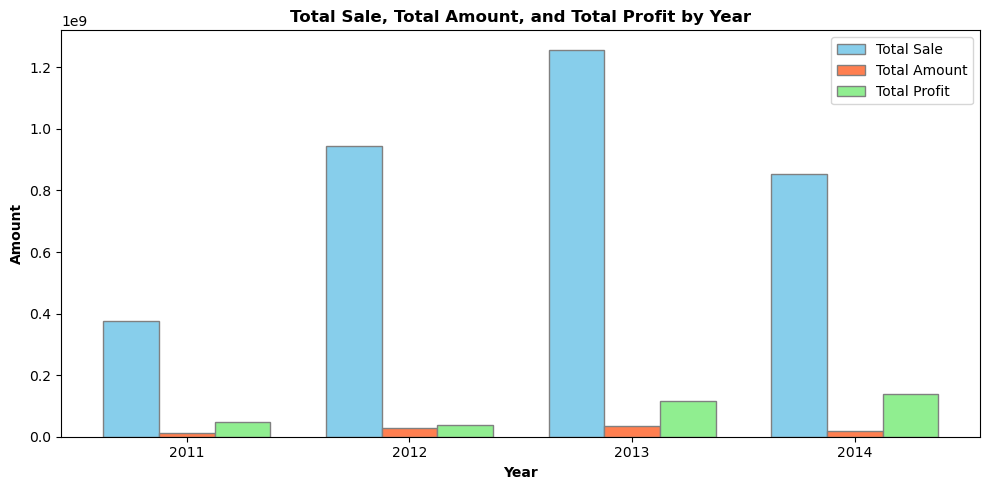

In [91]:
# Group the data only by 'Year' and aggregate the values to see the clear view of barchart

grouped_df = df.groupby(['Year']).agg({'TotalSale': 'sum', 'TotalAmount': 'sum', 'TotalProfit': 'sum'}).reset_index()

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.25
r1 = range(len(grouped_df['Year']))  # Position for Total Sale bars on X axis
r2 = [x + bar_width for x in r1]     # Position for Total Amount bars
r3 = [x + bar_width for x in r2]     # Position for Total Profit bars

# Plot Total sale, Total Amount and total profit
ax.bar(r1, grouped_df['TotalSale'], color='skyblue', width=bar_width, edgecolor='grey', label='Total Sale')
ax.bar(r2, grouped_df['TotalAmount'], color='coral', width=bar_width, edgecolor='grey', label='Total Amount')
ax.bar(r3, grouped_df['TotalProfit'], color='lightgreen', width=bar_width, edgecolor='grey', label='Total Profit')

# Add labels and title
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Amount', fontweight='bold')
ax.set_title('Total Sale, Total Amount, and Total Profit by Year', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(len(grouped_df['Year']))])  # Set x-axis labels and adjust positions
ax.set_xticklabels(grouped_df['Year'].astype(str))
ax.legend()
plt.tight_layout()
plt.show()


In [93]:
query = """WITH RankedTransactions AS (
    SELECT 
        P.ProductID, 
        P.Name AS ProductName, 
        SOD.LineTotal AS TotalAmount,
        (SOD.LineTotal - (SOD.OrderQty * P.StandardCost)) AS Profit,
        YEAR(SOH.OrderDate) AS Year,
        MONTH(SOH.OrderDate) AS Month,
        ROW_NUMBER() OVER (PARTITION BY YEAR(SOH.OrderDate), MONTH(SOH.OrderDate) ORDER BY SOD.LineTotal DESC) AS RowNum
    FROM 
        Production.Product P
    JOIN 
        Production.ProductSubcategory PSC ON P.ProductSubcategoryID = PSC.ProductSubcategoryID
    JOIN 
        Production.ProductCategory PC ON PSC.ProductCategoryID = PC.ProductCategoryID
    JOIN 
        Sales.SalesOrderDetail SOD ON P.ProductID = SOD.ProductID
    JOIN 
        Sales.SalesOrderHeader SOH ON SOD.SalesOrderID = SOH.SalesOrderID
    WHERE 
        PC.Name = 'Bikes' AND PSC.Name = 'Mountain Bikes'
)
SELECT * FROM RankedTransactions WHERE RowNum <= 10;
"""

In [95]:
df_mountain= pd.read_sql(query,engine)


In [97]:
print(df_mountain)

     ProductID             ProductName  TotalAmount     Profit  Year  Month  \
0          777  Mountain-100 Black, 44    12149.964   761.3976  2011      5   
1          778  Mountain-100 Black, 48    12149.964   761.3976  2011      5   
2          775  Mountain-100 Black, 38    10124.970   634.4980  2011      5   
3          778  Mountain-100 Black, 48    10124.970   634.4980  2011      5   
4          777  Mountain-100 Black, 44    10124.970   634.4980  2011      5   
..         ...                     ...          ...        ...   ...    ...   
365        782  Mountain-200 Black, 38    11015.952  1000.1016  2014      5   
366        782  Mountain-200 Black, 38    11015.952  1000.1016  2014      5   
367        782  Mountain-200 Black, 38    11015.952  1000.1016  2014      5   
368        784  Mountain-200 Black, 46    11015.952  1000.1016  2014      5   
369        782  Mountain-200 Black, 38    11015.952  1000.1016  2014      5   

     RowNum  
0         1  
1         2  
2        

In [99]:
# Calculate mean and standard error for Total Amount
mean_total_sale_mountain = df_mountain['TotalAmount'].mean()
sem_total_sale_mountain = stats.sem(df_mountain['TotalAmount'])

# Calculate 95% confidence interval for Total Amount
confidence_interval_total_sale = stats.t.interval(0.95, len(df_mountain['TotalAmount'])-1, loc=mean_total_sale_mountain, scale=sem_total_sale_mountain)

# Calculate mean and standard error for Profit
mean_profit = df_mountain['Profit'].mean()
sem_profit = stats.sem(df_mountain['Profit'])

# Calculate 95% confidence interval for Profit
confidence_interval_profit = stats.t.interval(0.95, len(df_mountain['Profit'])-1, loc=mean_profit, scale=sem_profit)

# Display the results
print(f"Mountain Bikes - Mean Total Sale: {mean_total_sale_mountain}")
print(f"Mountain Bikes - 95% Confidence Interval for Total Sale: {confidence_interval_total_sale}")
print(f"Mountain Bikes - Mean Profit: {mean_profit}")
print(f"Mountain Bikes - 95% Confidence Interval for Profit: {confidence_interval_profit}")

Mountain Bikes - Mean Total Sale: 11023.32222254054
Mountain Bikes - 95% Confidence Interval for Total Sale: (10528.242938276795, 11518.401506804286)
Mountain Bikes - Mean Profit: 181.40672875675668
Mountain Bikes - 95% Confidence Interval for Profit: (-38.087680752186714, 400.90113826570007)


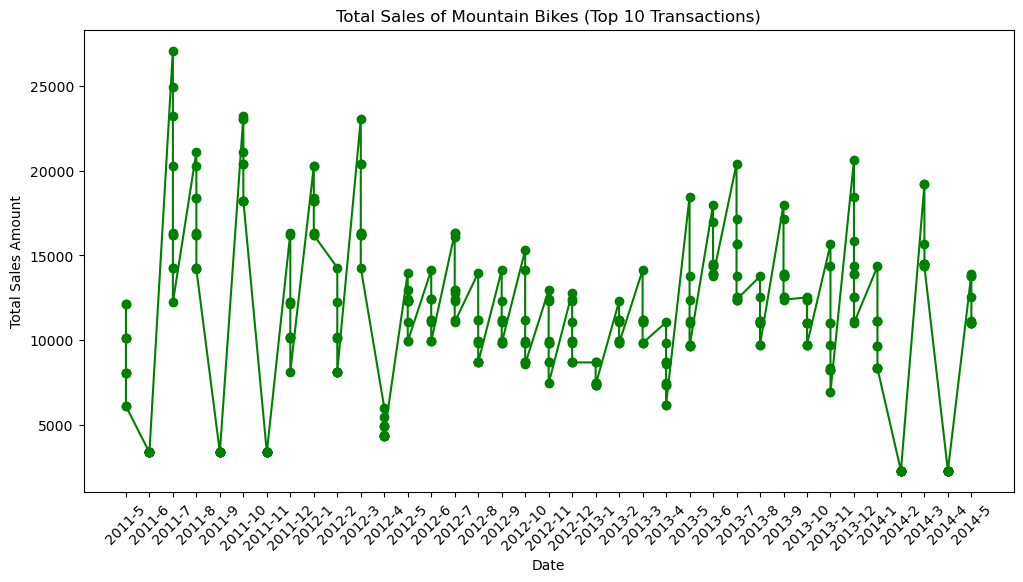

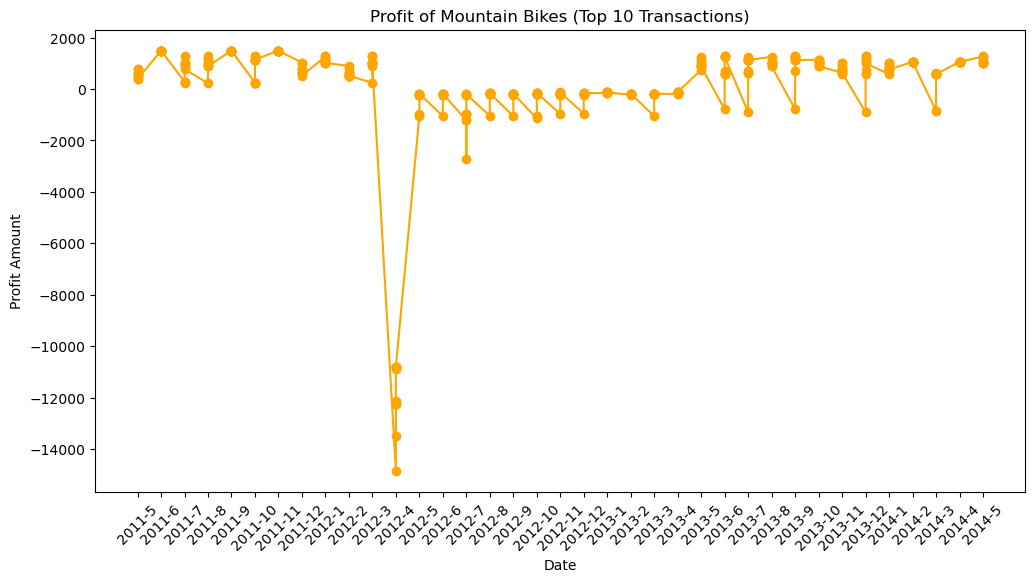

In [101]:
# Sort the data by Year and Month
df_mountain = df_mountain.sort_values(by=['Year', 'Month'])

# Create a new column for Date
df_mountain['Date'] = df_mountain['Year'].astype(str) + '-' + df_mountain['Month'].astype(str)

# Plotting the line chart
plt.figure(figsize=(12, 6))
plt.plot(df_mountain['Date'], df_mountain['TotalAmount'], marker='o', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.title('Total Sales of Mountain Bikes (Top 10 Transactions)')
plt.xticks(rotation=45) # Rotates the x_axis labels for better readability
plt.show()

# Plotting the line chart for Profit
plt.figure(figsize=(12, 6))
plt.plot(df_mountain['Date'], df_mountain['Profit'], marker='o', linestyle='-', color='orange')
plt.xlabel('Date')
plt.ylabel('Profit Amount')
plt.title('Profit of Mountain Bikes (Top 10 Transactions)')
plt.xticks(rotation=45)  # Rotates the x_axis labels for better readability
plt.show()
